# <center> 4.2 - LightGBM</center> 

<center><img src="https://lightgbm.readthedocs.io/en/latest/_images/LightGBM_logo_black_text.svg" width="400" height="100"></center>

LGBM (Light Gradient Boosted Machine) - была описана Голинь К., и соавт. в статье 2017 года [«LightGBM: A Highly Efficient Gradient Boosting Decision Tree»](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree). Реализация вводит две ключевые идеи: GOSS и EFB.<br>
<br>
С помощью GOSS (Градиентная односторонняя выборка) мы исключаем значительную часть экземпляров данных с небольшими градиентами и используем оставшиеся экземпляры для оценки прироста информации. Было доказано, что, поскольку экземпляры данных с большими градиентами играют более важную роль, GOSS может получить довольно точную оценку с гораздо меньшим размером данных. <br>
<br>
Exclusive Feature Bundling (объединение взаимоисключающих признаков), или EFB, — это подход объединения разреженных (в основном нулевых) взаимоисключающих признаков, таких как категориальные переменные, закодированные onehot  кодированием. Это, по сути, тип автоматического подбора признаков.
>… мы пакетируем взаимоисключающие признаки (то есть они редко принимают ненулевые значения одновременно), чтобы уменьшить количество признаков.
<br>
<br>
>Мы называем нашу новую реализацию GBDT с помощью GOSS и EFB LightGBM. Наши эксперименты на нескольких общедоступных наборах данных показывают, что LightGBM ускоряет процесс обучения обычного GBDT более чем в 20 раз, достигая почти такой же точности.

In [ ]:
!pip install sklearn lightgbm

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [118]:
# Загружаем train-датасет который мы сохранили на шаге quickstart
rides_info = pd.read_csv('../data/quickstart_train.csv')
rides_info.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,15634.32,another_bug,44.660920,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,2791.94,electro_bug,49.862069,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,2263.93,gear_stick,44.005747,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,1518.06,engine_fuel,49.344828,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,825.78,engine_fuel,50.603448,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [119]:
drop_cols = ['car_id', 'target_reg', 'target_class']
cat_cols = ['car_type', 'fuel_type', 'model']

In [120]:
# заполним пропущенные значения медианным значением по столбцу
rides_info.fillna(rides_info.median(), inplace=True)

In [121]:
X = rides_info.drop(drop_cols, axis=1)
y = rides_info['target_class']

## Dataset

Как в библиотеке Catobost есть класс Pool для создания датасетов, так и в LightGBM есть класс Dataset для той же цели. Как заявлено, является очень эффективным по потребляемой памяти, т.к. хранит не конкретные значения признаков, а только их дискретные бины. Число бинов, в свою очередь, можно регулировать в при создании датасета, уменьшив параметры `max_bin` или `max_bin_by_feature`. <br>
>The Dataset object in LightGBM is very memory-efficient, it only needs to save discrete bins. 

В документации заявлено, что в него можно подавать категориальные фичи без one-hot энкодинга, но реализовано это специфическим образом: категориальные фичи надо привести к целочисленному типу (int32).
>LightGBM can use categorical features as input directly. It doesn’t need to convert to one-hot encoding, and is much faster than one-hot encoding (about 8x speed-up).
Note: You should convert your categorical features to int type before you construct Dataset.

Целевая переменная - (параметр `label`) так же ограничен по возможным типам: int, float или bool

In [122]:
# переведем категориальные фичи в int с помощью  LabelEncoder
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

# таргет так же придется перевести из строкового типа в целочисленный
le_tar = LabelEncoder()
y = le_tar.fit_transform(y)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [124]:
train_data = lgb.Dataset(X_train, y_train, categorical_feature=cat_cols, free_raw_data=False)
val_data = lgb.Dataset(X_test, y_test, categorical_feature=cat_cols, free_raw_data=False)

Ниже приведены другие важные параметры:

* `feature_name` — принимает список строк, определяющих имена столбцов.
* `reference` — (Dataset or None, optional (default=None)) – Если это Dataset для валидации, то тренировочный Dataset должен быть указан как референсный.
* `group` – используется при решении задачи ранжирования (обучении Ранкера).
* `weight` – можно указать список весов для каждого экземпляра данных (не отритцательные числа) или установить позже, используя метод `set_weight()`.
* `params` – принимает словарь параметров, здесь, как раз, можно указать количество бинов (`max_bin` или `max_bin_by_feature`).
* `free_raw_data` (bool, optional (default=True)) – отвечает за освобождение памяти от сырых данных после создания датасета.
>Numpy/Array/Pandas object is memory expensive. If you are concerned about your memory consumption, you can save memory by:

>1. Set free_raw_data=True (default is True) when constructing the Dataset

>2. Explicitly set raw_data=None after the Dataset has been constructed

>3. Call gc()


## Два основных способа создания и обучения модели в LightGBM

Хотя существуют другие, и каждый имеет свои удобства, преимущества и недостатки. 

* 1. Метод `train()` класса `Booster` - наиболее простой и универсальный способ.
* 2. Класс `LGBMModel` с привычными методами `fit()`, `predict()`, который предоставляет подобный scikit-learn API для обучения и прогнозирования в lightgbm, а так же позволяет использовать обученные модели в пайплайнах sklearn (например при стэккинге).

Рассмотрим каждый из способов на примере нашей задачи и познакомимся с основными параметрами.

### **Обучение модели методом train()**

Самый простой способ создать модель в lightgbm — использовать метод `train()`. Он принимает на вход словарь параметров и обучающий датасет.
После обучения возвращается объект типа Booster, который является обученной моделью: её можно использовать для будущих предсказаний.

Ниже приведены некоторые из важных параметров метода train().

* `params` — это словарь, определяющий параметры модели. Нам просто нужно предоставить целевую функцию для начала работы в зависимости от типа задачи (классификация/регрессия). Позже мы ознакомимся с часто используемым списком параметров, которые можно передать в этот словарь.
*  `train_set` — этот параметр принимает объект типа Dataset, который содержит информацию о признаках и целевых значениях.
* `num_boost_round` — указывает количество деревьев бустинга, которые будут использоваться в ансамбле (по умолчанию равно 100).
* `valid_sets` — принимает список Dataset объектов, которые являются выборками для валидации. Эти проверочные датасеты оцениваются после каждого цикла обучения.
* `valid_names` — принимает список строк той же длины, что и у valid_sets, определяющих имена для каждой проверочной выборки. Эти имена будут использоваться при выводе оценочных метрик для валидационных наборов данных, а также при их построении.
* `categorical_feature` — принимает список строк/целых чисел или строку auto. Если мы передадим список строк/целых чисел, тогда указанные столбцы из набора данных будут рассматриваться как категориальные.
* `verbose_eval` — принимает значения типа bool или int. Определяет с какой частотой выводить результаты расчета метрик на проверочных выборках.

In [125]:
params = {"objective": "multiclass", 
          "num_class":9,
          "verbosity": -1,
}

booster = lgb.train(params,
                    train_set=train_data, valid_sets=(val_data,),
                    num_boost_round=10)

# В случае мультиклассификации метод predict() возвращает вероятности классов, поэтому используем np.argmax()
test_preds = np.argmax(booster.predict(X_test), axis=1)
print("\nTest Accuracy: %.2f"%accuracy_score(y_test, test_preds))

[1]	valid_0's multi_logloss: 1.74731
[2]	valid_0's multi_logloss: 1.50997
[3]	valid_0's multi_logloss: 1.34305
[4]	valid_0's multi_logloss: 1.22257
[5]	valid_0's multi_logloss: 1.1227
[6]	valid_0's multi_logloss: 1.0441
[7]	valid_0's multi_logloss: 0.983687
[8]	valid_0's multi_logloss: 0.9355
[9]	valid_0's multi_logloss: 0.893843
[10]	valid_0's multi_logloss: 0.85885

Test Accuracy: 0.71


Метод `predict()` так же имеет ряд параметров и может возвращать SHAP values, raw_score и пр. <br>
Подробнее можно ознакомиться в [документации](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Booster.html#lightgbm.Booster.predict)

### **Обучение и создание моделей, используя обертку класса Booster**
Обертки для класса Booster, которые предоставляют подобный scikit-learn API для обучения и прогнозирования в lightgbm. Позволяют создать модель со списком параметров в качестве входных данных. Затем можно вызвать метод `fit()` для обучения, передав ему тренировочные данные, и метод `predict()` для предсказания.<br>
Параметры, которые мы передали в виде словаря аргументу `params` метода `train()`, теперь можно напрямую передать конструктору класса-обертки для создания модели. <br>
Виды оберток класса Booster:
* `LGBMModel` — универсальная обертка, позволяет нам выполнять задачи как классификации, так и регрессии, указав цель (objective) задачи.<br> Например: `model = LGBMModel(objective="regression", n_estimators=10)` для задачи регрессии.
* `LGBMClassifier` — работает точно так же, как LGBMModel, но только для задач классификации. Он также предоставляет метод `score()`, который оценивает точность переданных ему данных. Стоит обратить внимание, что LGBMClassifier предсказывает фактические метки классов для задач классификации с помощью метода `predict()`. Так же предоставлен метод `pred_proba()`, если нам нужны вероятности целевых классов.
* `LGBMRegressor` — как следует из названия, он предназначен для задач регрессии.
* `LGBMRanker` — используется для задач ранжирования.


In [127]:
# Заметим, что метод fit() не принимает объект класса Dataset
# поэтому передадим номера категориальных столбцов в параметр cat_feature
clf = lgb.LGBMClassifier(objective="multiclass", 
                         n_estimators=10,
                         num_class=9,
                         seed=42,
                         cat_feature=[0,1,2],
                        )

clf.fit(X_train, y_train, eval_set=[(X_test, y_test),])

[1]	valid_0's multi_logloss: 1.74731
[2]	valid_0's multi_logloss: 1.50997
[3]	valid_0's multi_logloss: 1.34305
[4]	valid_0's multi_logloss: 1.22257
[5]	valid_0's multi_logloss: 1.1227
[6]	valid_0's multi_logloss: 1.0441
[7]	valid_0's multi_logloss: 0.983687
[8]	valid_0's multi_logloss: 0.9355
[9]	valid_0's multi_logloss: 0.893843
[10]	valid_0's multi_logloss: 0.85885


LGBMClassifier(cat_feature=[0, 1, 2], n_estimators=10, num_class=9,
               objective='multiclass', seed=42)

In [128]:
# В данном случае метод predict() возвращает сразу метку класса, поэтому np.argmax() не нужен
test_preds = clf.predict(X_test)
print("\nTest Accuracy: %.2f" % accuracy_score(y_test, test_preds))


Test Accuracy: 0.71


## <center>Важные параметры LightGBM.</center>

Особенность LightGBM — в том, что он поддерживает ряд алгоритмов бустинга, называемых типами бустинга. Тип бустинга указывается с помощью аргумента `boosting_type`.<br> Возможные значения:
* `gbdt` - градиеный бустинг над решающими деревьями (используется по умолчанию);
* `dart` - понятие отсева (dropout) вводится в MART, получаем DART (как [droput](https://ru.wikipedia.org/wiki/%D0%98%D1%81%D0%BA%D0%BB%D1%8E%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_(%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8)) слой в нейронках);
* `goss` - односторонняя выборка на основе градиента (GOSS).
* `rf` - Random Forest


`objective` — этот параметр позволяет нам определить целевую функцию, используемую для текущей задачи. Его значением по умолчанию является regression. На данный момент поддерживается 16 таких функций. Ниже приведен список часто используемых значений этого параметра.
- `regression` (L2 loss)
- `regression_l1` (L1 loss)
- `tweedie`
- `binary`
- `multiclass`
- `multiclassova`
- `cross_entropy`
- `lambdarank` <br>
[Другие доступные целевые функции](https://lightgbm.readthedocs.io/en/latest/Parameters.html#objective)

`metric` — данный параметр принимает метрики для расчета на оценочных наборах данных. Мы можем предоставить более одной метрики, и все они будут посчитаны на проверочных датасетах. Ниже приведен список наиболее часто используемых значений этого параметра.

* `rmse`
* `l2`
* `l1`
* `binary_logloss`
* `multi_logloss`
* `auc`
* `cross_entropy` <br>
[Другие доступные метрики](https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric)

`num_iterations` — данный параметр является псевдонимом для `num_boost_round`, который позволяет нам указать число деревьев в ансамбле для создания модели. По умолчанию 100. <br>
`learning_rate` — этот параметр используется для определения скорости обучения. По умолчанию 0.1. <br>
`num_leaves` — данный параметр принимает целое число, определяющее максимальное количество листьев, разрешенное для каждого дерева. По умолчанию 31.<br>
`max_depth` — этот параметр позволяет нам указать максимальную глубину, разрешенную для деревьев в ансамбле. По умолчанию -1, что позволяет деревьям расти как можно глубже. Мы можем ограничить это поведение, установив этот параметр.<br>
`min_data_in_leaf` — данный параметр принимает целочисленное значение, определяющее минимальное количество точек данных (семплов), которые могут храниться в одном листе дерева. Этот параметр можно использовать для контроля переобучения. Значение по умолчанию 20.<br>
`bagging_fraction` — этот параметр принимает значение с плавающей запятой от 0 до 1, которое позволяет указать, насколько большая часть данных будет случайно отбираться при обучении. Этот параметр может помочь предотвратить переобучение. По умолчанию 1.0.<br>
`feature_fraction` — данный параметр принимает значение с плавающей запятой от 0 до 1, которое информирует алгоритм о выборе этой доли показателей из общего числа для обучения на каждой итерации. По умолчанию 1.0, поэтому используются все показатели.<br>
`extra_trees` — этот параметр принимает логические значения, определяющие, следует ли использовать чрезвычайно рандомизированное дерево или нет.<br>
<br>
`num_class` — если мы работаем с задачей мультиклассовой классификации, то этот параметр должен содержать количество классов.<br>
`is_unbalance` — это логический параметр, который должен иметь значение `True`, если данные не сбалансированы. Его следует использовать с задачами бинарной и мультиклассовой классификации.<br>
<br>
`force_col_wise` — этот параметр принимает логическое значение, определяющее, следует ли принудительно строить гистограмму по столбцам при обучении. Если в данных слишком много столбцов, установка для этого параметра значения True повысит скорость процесса обучения за счет уменьшения использования памяти.<br>
`force_row_wise` — этот параметр принимает логическое значение, определяющее, следует ли принудительно строить гистограмму по строкам при обучении. Если в данных слишком много строк, установка для этого параметра значения True повысит скорость процесса обучения за счет уменьшения использования памяти.<br>
`early_stopping_round` — принимает целое число, указывающее, что мы должны остановить обучение, если оценочная метрика, рассчитанная на последнем проверочном датасете, не улучшается на протяжении определенного параметром числа итераций.

Это далеко не полный список параметров, а наиболее важные. [Описание всех параметров](https://lightgbm.readthedocs.io/en/latest/Parameters.html)

In [129]:
#посмотрим как меняется точность в зависимости от типа бустинга
boostings = ['gbdt', 'dart', 'goss']

for name in boostings:
    clf = lgb.LGBMClassifier(objective="multiclass", 
                             n_estimators=20,
                             learning_rate=0.05,
                             num_class=9,
                             seed=42,
                             cat_feature=[0, 1, 2],
                             boosting_type=name,
                            )
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test),], verbose=False)
    test_preds = clf.predict(X_test)
    print("{} accuracy: {:.2f}".format(name, accuracy_score(y_test, test_preds)))

gbdt accuracy: 0.72
dart accuracy: 0.71
goss accuracy: 0.72


 Как видно, отличия небольшие. Про подбор оптимальных параметров смотрите урок про Optuna.

## Тюнинг параметров.
**Чтобы повысить точность модели:**
* Использовать большой `max_bin` (замедляет обучение)
* Уменьшить `learning_rate`, увеличив число деревьев `num_iterations`
* Увеличить `num_leaves` (может привести к оверфиттингу)
* Попробовать dart<br>

**Для борьбы с переобучением:**
* Уменьшить `max_bin` и `num_leaves`
* Использовать `min_data_in_leaf` и `min_sum_hessian_in_leaf`
* Использовать [бэггинг](https://ru.wikipedia.org/wiki/%D0%91%D1%8D%D0%B3%D0%B3%D0%B8%D0%BD%D0%B3), указав `bagging_fraction` и `bagging_freq`
* Использовать сабсэмплинг признаков, установив `feature_fraction`
* Попробовать `lambda_l1`, `lambda_l2`, `min_gain_to_split` и `extra_trees` для регуляризации
* Установить `max_depth` для ограничения глубины дерева<br>

Про `max_depth`: LightGBM строит асимметричное дерево, в отличие от других бустингов (разработчики указывают это как киллер-фичу), поэтому по умолчанию этот парметр выставлен в -1 (неограниченная глубина дерева). Но чтобы не расти до бесконечности и не запомнить все данные, особенно на небольших датасетах, рекомендуется ограничивать глубину дерева другими параметрами: `num_leaves`, `min_data_in_leaf`, `min_sum_hessian_in_leaf`, `min_data_in_bin`, `min_gain_to_split`. А `max_depth` рекомендуется использовать либо на очень маленьких (для борьбы с оверфитом), либо на очень больших датасетах (чтобы уменьшить время обучения).

<center> <img src = '../images/3_boostings.webp'> </center>

## Early stopping

Для early_stopping'а необходимо задать хотя бы 1 валидационный датасет в `valid_sets`
В LightGBM есть два способа задействовать механизм ранней остановки обучения модели (early_stopping):
* 1. Задать количество итераций в параметре `early_stopping_round`  через которое обучение остановится, если скор на валидации не меняется.
* 2. Использовать механизм обратных вызовов (callbacks) метода `train()`.<br>
Пример: 
```python
bst = lgb.train(param, train_data, num_round, valid_sets=valid_sets, callbacks=[lgb.early_stopping(stopping_rounds=5)])
```

Так же есть callback constructor в котором можно задать более сложную логику срабатывания early stopping'а, например, если используются несколько метрик для валидации и одна должна расти, а другая падать. Более подробно можно ознакомиться в документации.

In [131]:
# Опробуем на нашем примере
clf = lgb.LGBMClassifier(objective="multiclass", 
                         n_estimators=100,
                         learning_rate=0.1,
                         num_class=9,
                         seed=42,
                         cat_feature=[0, 1, 2],
                        )

clf.fit(X_train, y_train,
        eval_set=[(X_test, y_test),], 
        early_stopping_rounds=5,)

[1]	valid_0's multi_logloss: 1.74731
[2]	valid_0's multi_logloss: 1.50997
[3]	valid_0's multi_logloss: 1.34305
[4]	valid_0's multi_logloss: 1.22257
[5]	valid_0's multi_logloss: 1.1227
[6]	valid_0's multi_logloss: 1.0441
[7]	valid_0's multi_logloss: 0.983687
[8]	valid_0's multi_logloss: 0.9355
[9]	valid_0's multi_logloss: 0.893843
[10]	valid_0's multi_logloss: 0.85885
[11]	valid_0's multi_logloss: 0.827409
[12]	valid_0's multi_logloss: 0.806586
[13]	valid_0's multi_logloss: 0.784776
[14]	valid_0's multi_logloss: 0.768039
[15]	valid_0's multi_logloss: 0.754988
[16]	valid_0's multi_logloss: 0.748208
[17]	valid_0's multi_logloss: 0.741854
[18]	valid_0's multi_logloss: 0.736293
[19]	valid_0's multi_logloss: 0.734452
[20]	valid_0's multi_logloss: 0.733365
[21]	valid_0's multi_logloss: 0.72929
[22]	valid_0's multi_logloss: 0.73008
[23]	valid_0's multi_logloss: 0.72704
[24]	valid_0's multi_logloss: 0.725782
[25]	valid_0's multi_logloss: 0.727151
[26]	valid_0's multi_logloss: 0.730593
[27]	vali

LGBMClassifier(cat_feature=[0, 1, 2], num_class=9, objective='multiclass',
               seed=42)

In [132]:
# Стоит отметить, что модель возвращается с лучшей итерацией после срабатывания остановки
clf.best_iteration_

24

## Сохранение и загрузка модели

Стоит обратить внимание на то, что для сохранения модели, обученной с использованием LGBMModel, LGBMRegressor и LGBMClassifier, нам сначала нужно получить их экземпляр `Booster` с помощью атрибута `booster_` модели, а затем сохранить его. LGBMModel, LGBMRegressor и LGBMClassifier не предоставляют функций сохранения и загрузки. Они доступны только с экземпляром `Booster`. <br>

Lightgbm предоставляет нижеперечисленные методы для сохранения и загрузки моделей.
* `save_model()` — этот метод принимает имя файла, в котором сохраняется модель.
* `model_to_string()` — данный метод возвращает строковое представление модели, которое мы затем можем сохранить в текстовый файл.
* `lightgbm.Booster()` — этот конструктор позволяет нам создать экземпляр класса Booster. У него есть два важных параметра, которые могут помочь нам загрузить модель из файла или из строки.
    - `model_file` — этот параметр принимает имя файла, из которого загружается обученная модель.
    - `model_str` — данный параметр принимает строку, содержащую информацию об обученной модели. Нам нужно передать этому параметру строку, которая была сгенерирована с помощью `model_to_string()` после загрузки из файла.
<br>

Сохраним обученную выше модель на диск, а потом загрузим её обратно.

In [133]:
# получаем экземпляр класса Booster 
booster = clf.booster_
booster.save_model('lgb.mod')

In [134]:
# Отметим, что после загрузки модель будет экземпляром класса Booster и соответственно метод predict() опять выдает вероятности
# Поэтому argmax()
loaded_booster = lgb.Booster(model_file="lgb.mod")
test_preds = np.argmax(loaded_booster.predict(X_test), axis=1)
print("Test Accuracy: %.2f" % accuracy_score(y_test, test_preds))

Test Accuracy: 0.71


## Scheduler в LightGBM

В LightGBM реализован механизм подобный шедулеру при обучении нейронных сетей, т.е. мы можем менять `learning_rate` в процессе обучения модели - иногда это бывает полезно, чтобы выжать из модели максимум. Механизм реализован на базе callback фуекции `reset_parameter()` - данная функция обратного вызова позволяет нам сбрасывать learning rate после каждой итерации. Она принимает массив, размер которого совпадает с их количеством, или функцию, возвращающую новую скорость обучения для каждой итерации.<br>
В параметр `callbacks` методов `train()` и `fit()` можно подать список функций обратного вызова.<br>
Пример:
```python
booster = lgb.LGBMModel(objective=mean_sqaured_error, n_estimators=10,)
booster.fit(X_train, Y_train,
            eval_set=[(X_test, Y_test),], eval_metric="rmse",
            callbacks=[lgb.reset_parameter(learning_rate=np.linspace(0.1,1,10).tolist()),
                       lgb.early_stopping(stopping_rounds=5)])
```

## Визуализация и feature importance

Экземпляр класса `Booster` имеет метод feature_importance(), который может возвращать нам важность признаков на основе значений выигрыша `booster.feature_importance(importance_type="gain")` и разделения `booster.feature_importance(importance_type="split")` деревьев.<br>
### `plot_importance()`
Встроенный метод `plot_importance()` принимает экземпляр класса Booster и с его помощью отображает важность признаков. У данного метода есть параметр `importance_type`. Если он установлен в значение `split`, то график будет отображать количество раз, которое каждый показатель использовался для разбиения. Если установлено значение `gain`, то будет показан выигрыш от соответствующих разделений. Значение параметра `important_type` по умолчанию `split`.<br>
Параметр `max_num_features` принимает целое число, определяющее, сколько признаков включить в график.

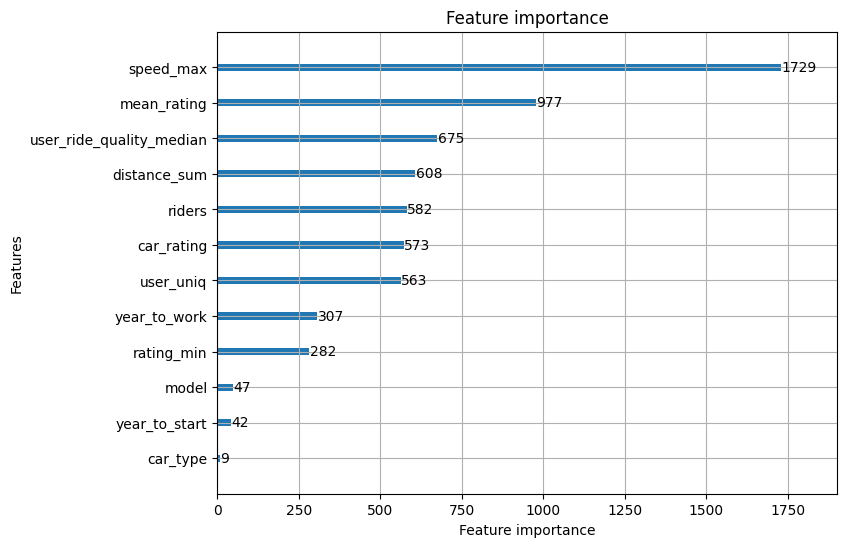

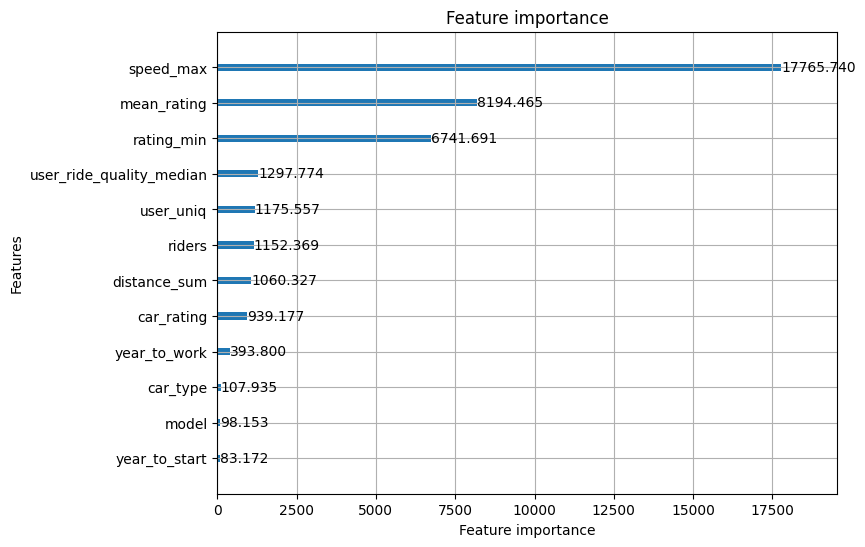

In [135]:
# Посмотрим на разные виды импортансов
lgb.plot_importance(booster, figsize=(8,6), importance_type='split');
lgb.plot_importance(booster, figsize=(8,6), importance_type='gain');

### `plot_split_value_histogram()`
Этот метод принимает на вход экземпляр класса Booster и имя/индекс признака. Затем он строит гистограмму значений разделения (split value) для выбранного признака.

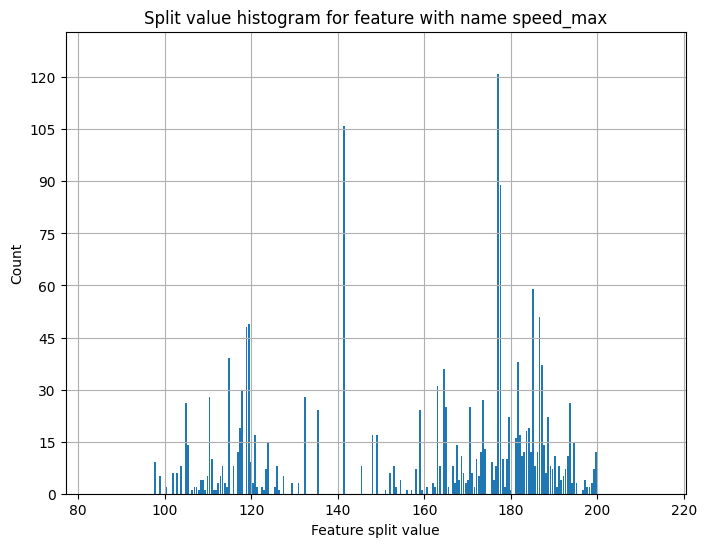

In [136]:
lgb.plot_split_value_histogram(booster, feature='speed_max', figsize=(8,6));

## Custom loss & custom eval functions
В некоторых соревнованиях организаторы считают скор для построения лидерборда на кокой-нибудь необычной функции оценки (eval metric), которая хорошо работает на конкретной задаче, но более нигде не встречается. Чаще всего, даже предоставляют формулу для расчета, в таком случае может быть полезно написать собственные кастомные функции для обучения бустинга.
LightGBM позволяет нам определять наши собственные функцию потерь и функцию оценки, если мы не хотим использовать метрики, предоставленные фреймворком.
Чаще всего используются 2 способа реализации кастомных функций:
* 1. Наиболее простой: импортировать готовую функцию из другого фреймворка (например из sklearn) и допилить до нужного формата (см. пример)
* 2. Написать собственную функцию с нуля.
### Функция потерь (Loss function)
Нужно создать функцию, которая принимает список прогнозируемых и фактических меток в качестве входных данных и возвращает первую и вторую производные функции потерь, вычисленные с использованием предсказанных и фактических значений. Далее мы можем при инициализации модели передать параметру `objective`  определенную нами функцию оценки/потерь. В случае использования метода train() мы должны предоставить ее через параметр `fobj`.
### Функция оценки (Eval function)
Создаем функцию, которая принимает на вход список предсказаний и фактических целевых значений. Она должна возвращать строку, определяющую название метрики, результат ее расчета и логическое значение, выражающее, стоит ли стремится к максимизации данной метрики или к ее минимизации. В случае, когда чем выше значение метрики, тем лучше, должно быть возвращено True, иначе — False. Нужно указать ссылку на эту функцию в параметре `feval`, если мы используем метод `train()` для обучения нашей модели. При передаче в `fit()` нам нужно присвоить данную ссылку параметру eval_metric.

In [116]:
#Рассмотрим в качестве примера реализацию кастомной метрики оценки 
from sklearn.metrics import precision_score

def precision_score_(preds: np.ndarray, data, threshold: float=0.5, num_classes: int=9):
    """Calculate recall_score"""
    label = data.get_label()
    preds = preds.reshape(num_classes, -1).T
    pred_label = np.argmax(preds, axis=1)
    rs = precision_score(pred_label, label, average='macro', zero_division=0)
    return 'precision_score', rs, True # eval_name, eval_result, is_higher_better

In [117]:
booster = lgb.train(params,
                    train_set=train_data, 
                    valid_sets=(val_data,),
                    num_boost_round=10,
                    feval=[precision_score_],)

[1]	valid_0's multi_logloss: 2.09804	valid_0's precision_score: 0.305134
[2]	valid_0's multi_logloss: 2.03213	valid_0's precision_score: 0.332209
[3]	valid_0's multi_logloss: 1.97896	valid_0's precision_score: 0.353609
[4]	valid_0's multi_logloss: 1.9346	valid_0's precision_score: 0.368696
[5]	valid_0's multi_logloss: 1.89426	valid_0's precision_score: 0.384341
[6]	valid_0's multi_logloss: 1.85953	valid_0's precision_score: 0.396159
[7]	valid_0's multi_logloss: 1.82945	valid_0's precision_score: 0.403395
[8]	valid_0's multi_logloss: 1.80209	valid_0's precision_score: 0.412722
[9]	valid_0's multi_logloss: 1.77683	valid_0's precision_score: 0.422687
[10]	valid_0's multi_logloss: 1.75438	valid_0's precision_score: 0.430404


## Полезные ссылки
* [Сборник победных решений хакатонов с использованием LightGBM](https://gist.github.com/GhibliField/d544464bc81f1d0f002bea243d80c51e)
* [Официальная документация библиотеки](https://lightgbm.readthedocs.io/en/latest/index.html)
* [Очень подробный гайд, переведенный на русский язык](https://pythonru.com/biblioteki/lightgbm)